# DPA on 1 round of PRESENT

In [1]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import statistics
import random
import math

# Hamming weights of numbers 0-15
HW = [0,1,1,2,1,2,2,3,1,2,2,3,2,3,3,4]

# PRESENT Sbox
S = [12,5,6,11,9,0,10,13,3,14,15,8,4,7,1,2]

In [2]:
#We first load data from the "random plaintext dataset", this set of traces will be used for our attack
file_no = 5000
traces = []
plaintexts = []

for i in range(file_no):
    with open('random_pt_dataset/trace_'+str(i)+'.txt') as f:
        lines = f.read().splitlines()
        traces.append(lines)

with open('random_pt_dataset/plaintexts.txt') as f:
    plaintexts = f.read().splitlines()
    
trace_array = np.array(traces)
trace_array = trace_array.astype(float)

In [3]:
#the target key nibble
correct_key = 9

#extract the plaintext nibble
plaintext_array = []
for i in range(file_no):
    plaintext_array.append(int(plaintexts[i][15],16))
plaintext_array = np.array(plaintext_array)

#number of time samples in one trace in the random plaintext dataset
N = 5000

In [4]:
##print some values
for i in range(2):
    print(plaintext_array[i])

9
12


In [5]:
#POIS
POIs_identity = [218,  392, 1328]
POIs_hw = [392, 1304, 1309]

In [6]:
#save data to file for tikz plot
def savetofile(filename,array):
    f = open(filename+".txt", "w")
    f.write("x y\n")
    i = 0
    for i in range(len(array)):
        f.write(str(i)+" "+str(array[i])+"\n")
        i+=1
    f.close()

In [7]:
#indices of traces/plaintexts used for computing success rate and guessing entropy
#generate random indices for traces in the attack set
no_of_attack = 100#number of attacks to do for computing GE
max_trace = 50 #maximum number of traces to consider
indall = [[] for i in range(max_trace+1)]
def set_up_indices():
    for no_of_traces in range(max_trace+1):
        indall[no_of_traces] = random.sample(range(file_no), no_of_traces*no_of_attack)
    return
set_up_indices()

## Correlation power analysis

In [8]:
#compute the correlation coefficients for all time samples given the leakage model
#0: identity leakage model
#1: Hamming weight leakage model
def compute_corr_coeff(leakage_model):
    #store hypotheses of intermediate values
    iv = [[0 for x in range(file_no)] for y in range(16)] 

    for i in range(16): #for each key hypothesis
        for j in range(file_no): #for each plaintext
            pt = plaintext_array[j] # get the target nibble of the plaintext
            iv[i][j] = S[i^pt] #compute the hypotheses of intermediate values
            if leakage_model == 1:
                iv[i][j] = HW[iv[i][j]]

    #store correlation coefficients for each time sample and each key hypothesis
    corr_coeff = [[0 for x in range(N)] for y in range(16)] 

    for t in range(N):
        for k in range(16): #for each key hypothesis
            #compute coefficient between the leakages at time sample t and the hypotheses
#             corr_coeff[k][t] = abs(np.corrcoef(trace_array[:,t],iv[k])[0][1])
            corr_coeff[k][t] = np.corrcoef(trace_array[:,t],iv[k])[0][1]
    return corr_coeff

In [9]:
# Plot the correlation
def plot_corre(corr_coeff):
    x = []
    
    for t in range(N):
        x.append(t)
        
    for k in range(16):
        if k == correct_key:
            plt.plot(x,corr_coeff[k],'b')
        else:
            plt.plot(x,corr_coeff[k],color="#808080")
        absolute_coefficients = []
        for t in range(N):
            absolute_coefficients.append(abs(corr_coeff[k][t]))
        #printing the correlation coefficients
        print("Maximum absolute correlation coefficient = " + str(max(absolute_coefficients)) + " for key hypothesis " + str(k) + " obtained at time sample " + str(absolute_coefficients.index(max(absolute_coefficients))))
    plt.show()
    
    return

### Identity leakage model

In [10]:
corr_coeff = compute_corr_coeff(0)

Maximum absolute correlation coefficient = 0.2773616383432746 for key hypothesis 0 obtained at time sample 392
Maximum absolute correlation coefficient = 0.3989460527872324 for key hypothesis 1 obtained at time sample 392
Maximum absolute correlation coefficient = 0.34343947704336314 for key hypothesis 2 obtained at time sample 1328
Maximum absolute correlation coefficient = 0.4640562086931642 for key hypothesis 3 obtained at time sample 1328
Maximum absolute correlation coefficient = 0.3749223846321691 for key hypothesis 4 obtained at time sample 392
Maximum absolute correlation coefficient = 0.41114720117375614 for key hypothesis 5 obtained at time sample 392
Maximum absolute correlation coefficient = 0.5483805379334337 for key hypothesis 6 obtained at time sample 392
Maximum absolute correlation coefficient = 0.4180828439723636 for key hypothesis 7 obtained at time sample 1310
Maximum absolute correlation coefficient = 0.16625545063410585 for key hypothesis 8 obtained at time sample

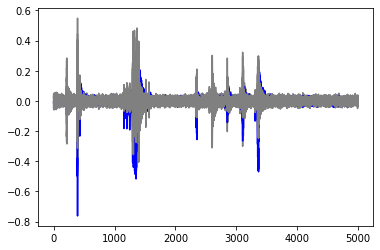

In [11]:
#plot the correlation coefficients
plot_corre(corr_coeff)

In [12]:
#save correlation coefficients to file
for i in range(16):
    filename = "DPA/key" + str(i)
    savetofile(filename,corr_coeff[i])

In [13]:
#three POIs, for the sake of comparison, seems different from what we get with SNR
array = np.zeros(file_no)
for i in range(file_no):
    array[i] = abs(corr_coeff[correct_key][i])
ind = np.argpartition(array, -3)[-3:]
print(ind)
print(array[ind])

[ 388  392 1354]
[0.49859989 0.76245372 0.51721215]


### Hamming weight leakage model

In [14]:
corr_coeff_HW = compute_corr_coeff(1)

Maximum absolute correlation coefficient = 0.39106898850769123 for key hypothesis 0 obtained at time sample 1310
Maximum absolute correlation coefficient = 0.473481008504195 for key hypothesis 1 obtained at time sample 392
Maximum absolute correlation coefficient = 0.30072158803121796 for key hypothesis 2 obtained at time sample 1317
Maximum absolute correlation coefficient = 0.4355147450283293 for key hypothesis 3 obtained at time sample 1328
Maximum absolute correlation coefficient = 0.39110540705622604 for key hypothesis 4 obtained at time sample 1317
Maximum absolute correlation coefficient = 0.4331246967912322 for key hypothesis 5 obtained at time sample 1328
Maximum absolute correlation coefficient = 0.5827308168821348 for key hypothesis 6 obtained at time sample 392
Maximum absolute correlation coefficient = 0.46951001995784913 for key hypothesis 7 obtained at time sample 392
Maximum absolute correlation coefficient = 0.3750934186665761 for key hypothesis 8 obtained at time samp

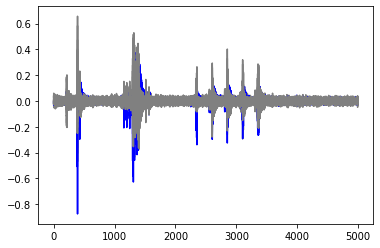

In [15]:
# Plot the correlation
plot_corre(corr_coeff_HW)

In [16]:
#save to file
for i in range(16):
    filename = "DPA/hw_key" + str(i)
    savetofile(filename,corr_coeff_HW[i])

In [17]:
#three POIs
array = np.zeros(file_no)
for i in range(file_no):
    array[i] = abs(corr_coeff_HW[correct_key][i])
ind = np.argpartition(array, -3)[-3:]
print(ind)
print(array[ind])

[1304  392 1309]
[0.57986044 0.87468016 0.62753151]


### DPA - Correlation coefficients against number of traces

In [18]:
#draw correlation coefficients against number of traces
#compute the correlation coefficients for one time sample given the plaintexts and the traces
#0: identity leakage model
#1: Hamming weight leakage model
#2: stochastic leakage model
def compute_corr_coeff_POI(leakage_model, POI, pts, no_of_traces, traces, sLM):
    #store hypotheses of intermediate values
    iv = [[0 for x in range(no_of_traces)] for y in range(16)] 

    for i in range(16): #for each key hypothesis
        for j in range(no_of_traces): #for each plaintext
            pt = pts[j] # get the target nibble of the plaintext
            iv[i][j] = S[i^pt] #compute the hypotheses of intermediate values
            if leakage_model == 1:
                iv[i][j] = HW[iv[i][j]]
            if leakage_model == 2:
                iv[i][j] = sLM[iv[i][j]]

    #store correlation coefficients for each time sample and each key hypothesis
    corr_coeff = [0 for y in range(16)] 

    for k in range(16): #for each key hypothesis
        #compute coefficient between the leakages at time sample POI and the hypotheses
        corr_coeff[k] = np.corrcoef(traces[:,POI],iv[k])[0][1]
    return corr_coeff

def cor_coeff_diff_trace(leakage_model, POI, max_no_trace, sLM):
    
    all_cor_coeff = [[0 for x in range(max_no_trace)] for y in range(16)]
    
    for no_of_traces in range(max_no_trace):
        ind = [i for i in range(no_of_traces)]
        traces = trace_array[ind]
        pts = plaintext_array[ind]
        corr_coeff_no_of_trace = compute_corr_coeff_POI(leakage_model, POI, pts, no_of_traces, traces, sLM)
        for k in range(16):
            all_cor_coeff[k][no_of_traces] = corr_coeff_no_of_trace[k]
    
    #plot correlation coefficients
    x = []
    for no_of_traces in range(max_no_trace):
        x.append(no_of_traces)
    for k in range(16):
        if k == correct_key:
            plt.plot(x,all_cor_coeff[k],'b')
        else:
            plt.plot(x,all_cor_coeff[k],color="#808080")
    plt.show()
    return all_cor_coeff
            

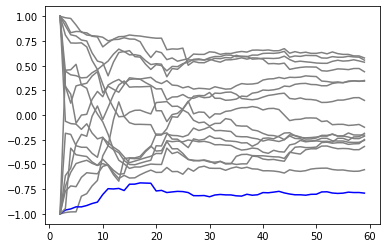

In [159]:
cor_coeff_diff_trace_identity = cor_coeff_diff_trace(0,392,60,0);
#save to file
for k in range(16):
    filename = "cor_coeff_diff_trace/key" + str(k)
    savetofile(filename,cor_coeff_diff_trace_identity[k])

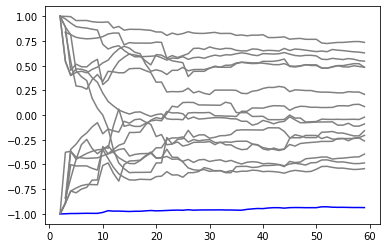

In [160]:
# Hamming weight model
cor_coeff_diff_trace_hw = cor_coeff_diff_trace(1,392,60,0);
#save to file
for k in range(16):
    filename = "cor_coeff_diff_trace/hw_key" + str(k)
    savetofile(filename,cor_coeff_diff_trace_hw[k])

#### What happens if we change the ordering of the traces

In [161]:
def cor_coeff_diff_trace_random(leakage_model, POI, max_no_trace):
    
    all_cor_coeff = [[0 for x in range(max_no_trace)] for y in range(16)]
    #get all indices in reverse order
    all_ind = [i for i in range(file_no)]
    all_ind.reverse()
    
    for no_of_traces in range(1,max_no_trace):
        ind = [all_ind[i] for i in range(no_of_traces)]
#         ind = random.sample(range(0, file_no), no_of_traces)
        traces = trace_array[ind]
        pts = plaintext_array[ind]
        corr_coeff_no_of_trace = compute_corr_coeff_POI(leakage_model, POI, pts, no_of_traces, traces, 0)
        for k in range(16):
            all_cor_coeff[k][no_of_traces] = corr_coeff_no_of_trace[k]
    
    #plot correlation coefficients
    x = []
    for no_of_traces in range(max_no_trace):
        x.append(no_of_traces)
    for k in range(16):
        if k == correct_key:
            plt.plot(x,all_cor_coeff[k],'b')
        else:
            plt.plot(x,all_cor_coeff[k],color="#808080")
    plt.show()
    return all_cor_coeff

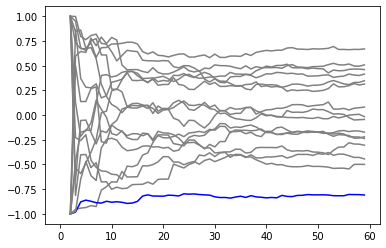

In [162]:
cor_coeff_diff_trace_identity_reverse = cor_coeff_diff_trace_random(0,392,60);
#save to file
for k in range(16):
    filename = "cor_coeff_diff_trace/reverse_key" + str(k)
    savetofile(filename,cor_coeff_diff_trace_identity_reverse[k])

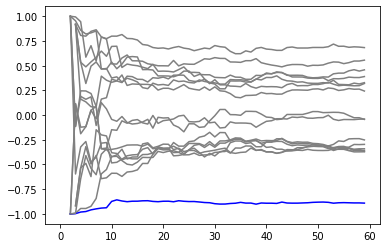

In [163]:
cor_coeff_diff_trace_hw_reverse = cor_coeff_diff_trace_random(1,392,60);
#save to file
for k in range(16):
    filename = "cor_coeff_diff_trace/reverse_hw_key" + str(k)
    savetofile(filename,cor_coeff_diff_trace_hw_reverse[k])

## Proflied DPA

### Stochastic Leakage Model

In [11]:
#Traces for profiling
#Loading file_no_rk traces to the variable traces_rk and the corresponding plaintexts to the variable plaintexts_rk
file_no_rk = 10000
traces_rk = []
plaintexts_rk = []
keys_rk = []

for i in range(file_no_rk):
    with open('random_dataset/trace_'+str(i)+'.txt') as f:
        lines = f.read().splitlines()
        traces_rk.append(lines)

with open('random_dataset/plaintexts.txt') as f:
    plaintexts_rk = f.read().splitlines()

with open('random_dataset/keys.txt') as f:
    keys_rk = f.read().splitlines()

trace_array_rk = np.array(traces_rk)
trace_array_rk = trace_array_rk.astype(float)

#extract the plaintext nibble
plaintext_array_rk = []
for i in range(file_no_rk):
    plaintext_array_rk.append(int(plaintexts_rk[i][15],16))
plaintext_array_rk = np.array(plaintext_array_rk)


#extract the key nibble
keys_array_rk = []
for i in range(file_no_rk):
    keys_array_rk.append(int(keys_rk[i][15],16))
keys_array_rk = np.array(keys_array_rk)


#number of time samples in one trace
N_rk = 5000

In [12]:
#print the 0th nibble of the first plaintext and key from the random dataset
print(plaintext_array_rk[0])
print(keys_array_rk[0])

4
7


In [22]:
##no_of_traces: number of traces to use for profiling
##POI: poi for profiling
def stochastic_LM(ind, POI):
    no_of_traces = len(ind)
    traces = trace_array_rk[ind]#take traces
    pts = plaintext_array_rk[ind]#take plaintext nibbles
    kys = keys_array_rk[ind]#take key nibbles
    leakages = traces[:,POI]
    M = np.zeros((no_of_traces, 4))#size of matrix M is no_of_traces*(bit length of v)
    for j in range(no_of_traces):
        xor_value = pts[j]^kys[j]
        v = S[xor_value] #intermediate value
        vbin = format(v,'b').zfill(4)#binary representation of v
        vbin_array = [int(vbin[i]) for i in range(4)]
        for i in range(4):
            M[j][i]=vbin_array[3-i]
    print(M[0])
    MT = np.transpose(M)
    A = np.linalg.inv(np.matmul(MT,M))
    alpha = np.matmul(A,MT)
    alpha = np.dot(alpha,leakages)
    
    return alpha

In [23]:
#print the first row of the matrix M
stochastic_LM([0,1,3,4,5,6,7],392)

[1. 1. 0. 1.]


array([-0.01041667, -0.03255208, -0.00423177, -0.02897135])

In [167]:
def stochastic_leakage_model(POI, attack_trace_no):
    ind_attack = [i for i in range(attack_trace_no)]
    alpha = stochastic_LM(ind_attack, POI)
    print("alpha values:")
    print(alpha)
    print("signals according to stochastic leakage model")
    slM = []
    for v in range(16):
        vbin = format(v,'b').zfill(4)#binary representation of v
        vbin_array = [int(vbin[i]) for i in range(4)]
        sleakage = 0
        for i in range(4):
            sleakage += alpha[i]*vbin_array[3-i]
        slM.append(sleakage)
        print(str(v) + " %.5f" % sleakage)
    return slM

In [168]:
slM = stochastic_leakage_model(392, file_no_rk)

alpha values:
[-0.02019722 -0.02026585 -0.0192008  -0.0203933 ]
signals according to stochastic leakage model
0 0.00000
1 -0.02020
2 -0.02027
3 -0.04046
4 -0.01920
5 -0.03940
6 -0.03947
7 -0.05966
8 -0.02039
9 -0.04059
10 -0.04066
11 -0.06086
12 -0.03959
13 -0.05979
14 -0.05986
15 -0.08006


In [169]:
def stochastic_attack(POI, attack_trace_no, max_trace):
    # compute correlation coefficients with stochastic leakage model
    cor_coeff_diff_trace_sto = cor_coeff_diff_trace(2,392,max_trace,slM);
    #save to file
    for k in range(16):
        filename = "cor_coeff_diff_trace/sto_key" + str(k)
        savetofile(filename,cor_coeff_diff_trace_sto[k])
    return 

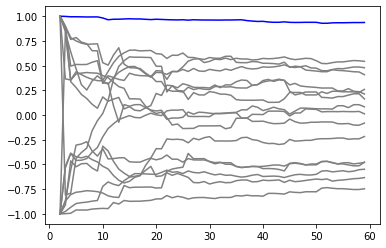

In [170]:
stochastic_attack(392, file_no_rk, 60)

### Guessing Entropy

In [193]:
#function to compute correlation coefficient for a given time sample (POI)
#lekage model has two choices: 
   #0: exact value of the 0th Sbox output
   #1: Hamming weight of the 0th Sbox output
   #2: stochastic leakage model
def cor_coe(POI, leakage_model, traces, pts, no_of_traces):
    #store hypotheses of intermediate values
    iv = [[0 for x in range(no_of_traces)] for y in range(16)] 

    for i in range(16): #for each key hypothesis
        for j in range(no_of_traces): #for each plaintext
            pt = pts[j]
            iv[i][j] = S[i^pt] #compute the hypotheses of 0th Sbox output
            if leakage_model == 1:
                iv[i][j] = HW[iv[i][j]]
            if leakage_model == 2:
                iv[i][j] = slM[iv[i][j]]

    corr = [0 for y in range(16)] #store correlation coefficients for each key nibble hypothesis
    for k in range(16):
        corr[k] = abs(np.corrcoef(traces[:,POI],iv[k])[0][1])
    
    return corr

#find the key rank given the POI, leakage_model, and traces
def key_rank(POI, leakage_model, traces, pts, no_of_traces):
    corr = cor_coe(POI, leakage_model, traces, pts, no_of_traces)
    corr_correct = corr[correct_key]
    corr.sort()
    rank = corr.index(corr_correct)
    return 16-rank

key_rank(392,0,trace_array,plaintext_array,file_no)

1

In [194]:
#Computing guessing entropy given the number of traces
def sr_ge(no_of_traces, POI):
    #identity
    ranks_identity = []
    sr_identity = 0
    #Hamming weight
    ranks_hw = []
    sr_hw = 0
    #stochastic leakage
    ranks_sto = []
    sr_sto = 0
    ##recall that indall contains no_of_traces*no_of_attack random indices for traces
    pts = [0 for j in range(no_of_traces)]
    for i in range(no_of_attack):#repeat no_of_attack experiments
        ind = indall[no_of_traces][i*no_of_traces:(i+1)*no_of_traces]
#         ind = random.sample(range(0, file_no),no_of_traces)
        traces = trace_array[ind]
        pts = plaintext_array[ind]
        r_id = key_rank(POI, 0, traces, pts, no_of_traces)#compute the key rank using the identity leakage model
        r_hw = key_rank(POI, 1, traces, pts, no_of_traces)#compute the key rank using the Hamming weight leakage model
        r_sto = key_rank(POI, 2, traces, pts, no_of_traces)#compute the key rank using the stochastic leakage model
        #record the correct key ranks for each attack
        ranks_identity.append(r_id)
        ranks_hw.append(r_hw)
        ranks_sto.append(r_sto)
        #record number of successful attacks
        if(r_id == 1):
            sr_identity += 1
        if(r_hw == 1):
            sr_hw += 1
        if(r_sto == 1):
            sr_sto +=1
    sr_identity = sr_identity/no_of_attack
    sr_hw = sr_hw/no_of_attack
    sr_sto = sr_sto/no_of_attack
    return sr_identity, sr_hw, sr_sto, statistics.mean(ranks_identity), statistics.mean(ranks_hw), statistics.mean(ranks_sto)

#compute GE for different number of traces
def SR_GE_compute(POI, max_trace):
    SR_id = [0,0]
    SR_hw = [0,0]
    SR_sto = [0,0]

    GE_id = [0,0]
    GE_hw = [0,0]
    GE_sto = [0,0]
    for no_of_traces in range(2,max_trace+1):
        sr_id, sr_hw, sr_sto, ge_id, ge_hw, ge_sto = sr_ge(no_of_traces, POI)
        SR_id.append(sr_id)
        SR_hw.append(sr_hw)
        SR_sto.append(sr_sto)
        GE_id.append(ge_id)
        GE_hw.append(ge_hw)
        GE_sto.append(ge_sto)
    
    # Placing the plots in the plane
    plot1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    plot2 = plt.subplot2grid((3, 3), (0, 2), rowspan=3, colspan=2)
    #plots
    plot1.plot(SR_id)
    plot1.plot(SR_hw)
    plot1.plot(SR_sto)
    plot1.set_title('SR')
    plot2.plot(GE_id)
    plot2.plot(GE_hw)
    plot2.plot(GE_sto)
    plot2.set_title('GE')

    # Packing all the plots and displaying them
    plt.tight_layout()
    plt.show()
    ##save to file
    savetofile("DPA/SR" + str(POI),SR_id)
    savetofile("DPA/SR_hw" + str(POI),SR_hw)
    savetofile("DPA/SR_sto" + str(POI),SR_sto)
    savetofile("DPA/GE" + str(POI),GE_id)
    savetofile("DPA/GE_hw" + str(POI),GE_hw)
    savetofile("DPA/GE_sto" + str(POI),GE_sto)
    return SR_id, SR_hw, GE_id, GE_hw

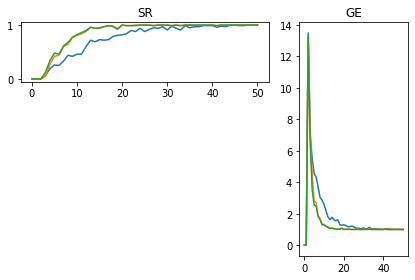

In [195]:
SR_GE_compute(392, 50);

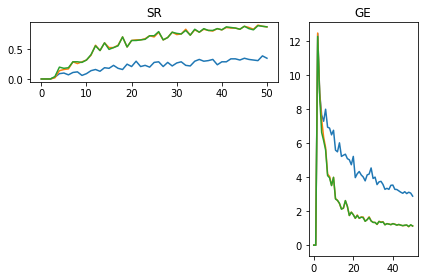

In [196]:
SR_GE_compute(1309, 50);

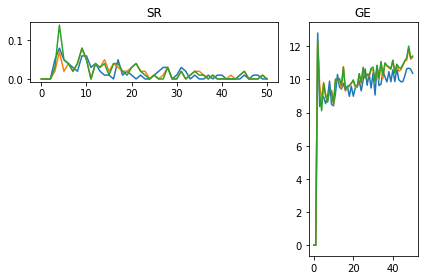

In [197]:
SR_GE_compute(218, 50);

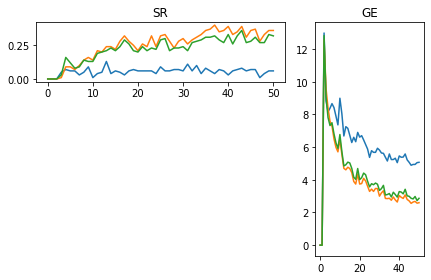

In [198]:
SR_GE_compute(1328, 50);

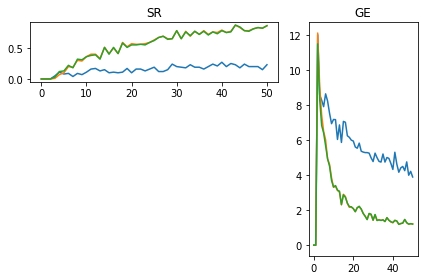

In [199]:
SR_GE_compute(1304, 50);

### Template-based DPA

In [13]:
#build template on POIs
def build_template(POIs, leakage_model):
    
    if leakage_model == 0:
        no_of_sets = 16 #for signal = identity, we group leakages into 16 sets
    elif leakage_model == 1:
        no_of_sets = 5 #for signal = hamming weight, we group leakages into 5 sets
    
    no_of_POIs = len(POIs)
    
    #record leakages at POIs for traces in each set
    poi_leakage = [[[] for y in range(no_of_POIs)] for x in range(no_of_sets)] 
    #separate leakages to sets depending on the Sbox output value and leakage model
    for j in range(file_no_rk): #for each plaintext in the profiling dataset
        pt = plaintext_array_rk[j] # get the target nibble of the plaintext
        keynibble = keys_array_rk[j]# get the corresponding nibble of the key
        iv = S[keynibble^pt] #compute the intermediate value
        if leakage_model == 1:
            iv = HW[iv]
        for poi_ind in range(no_of_POIs):
            poi_leakage[iv][poi_ind].append(trace_array_rk[j,POIs[poi_ind]])

    
    #compute mean vectors
    mean_vector = [[0 for x in range(no_of_POIs)] for y in range(no_of_sets)]
    for i in range(no_of_sets):
        for j in range(no_of_POIs):
            mean_vector[i][j] = statistics.mean(poi_leakage[i][j])
    #compute covariance matrix
    cov_matrix = [[] for y in range(no_of_sets)]
    for i in range(no_of_sets):
        cov_matrix[i] = np.cov(poi_leakage[i], bias=True)
    
    #return mean vector and the covariance matrices
    return mean_vector,cov_matrix

In [14]:
#Attack with attack traces "random_dataset"
#compute the score of each key hypothesis given the set of traces, the corresponding plaintext nibbles pts and the templates
#mean_vector and cov_matrix contain the templates
#key_nibble is the value of the correct key nibble
def template_prob_score(POIs, leakage_model, no_of_traces, pts, traces, mean_vector, cov_matrix, independence):
    
    if leakage_model == 0:
        no_of_sets = 16 #for signal = identity, we group leakages into 16 sets
    elif leakage_model == 1:
        no_of_sets = 5 #for signal = hamming weight, we group leakages into 5 sets
    
    no_of_POIs = len(POIs)
    prob = [0 for x in range(16)]#score for each key hypothesis
    
    #group the traces according to the key hypothesis
    for k in range(16): #for each key hypothesis
        #compute score of each trace
        for j in range(no_of_traces): #for each trace
            pt = pts[j] # get the target nibble of the plaintext
            iv = S[k^pt] #compute the intermediate value
            if leakage_model == 1:
                iv = HW[iv]
            #leakges at POIs
            trace_leakage = traces[j,POIs]
            #compute the score of this trace using the template
            mean_dif = trace_leakage-mean_vector[iv]
            
            #np.linalg.inv
            
            if no_of_POIs == 1:
                trace_prob = math.log(cov_matrix[iv])+(mean_dif*mean_dif)/cov_matrix[iv]
            else:
                if independence == 1:
                    #assume the leakages at different time samples are independent, creat a diagonal covariance matrix
                    #that only contains the variances
                    diagonal_matrix = np.zeros((no_of_POIs,no_of_POIs))
                    for i in range(no_of_POIs):
                        diagonal_matrix[i][i] = cov_matrix[iv][i][i]
                    mean_dif_cov = np.dot(mean_dif,np.linalg.inv(diagonal_matrix))
                    trace_prob = np.dot(mean_dif_cov,mean_dif) + math.log(np.linalg.det(diagonal_matrix))
                else:
                    mean_dif_cov = np.dot(mean_dif,np.linalg.inv(cov_matrix[iv]))
                    trace_prob = np.dot(mean_dif_cov,mean_dif) + math.log(np.linalg.det(cov_matrix[iv]))
            prob[k] -= trace_prob
    return prob

def compute_rank(probs, key):
    prob_sorted = []
    for k in range(16):
        prob_sorted.append(probs[k])
    prob_correct = prob_sorted[key]
    prob_sorted.sort()
    rank = prob_sorted.index(prob_correct)
    return 16-rank #the key with the lowest score is the best

mean_vector_identity, cov_matrix_identity = build_template([392],0)
test_rank = compute_rank(template_prob_score([392], 0, file_no, plaintext_array, trace_array, mean_vector_identity, cov_matrix_identity,0),9)
print(test_rank)

1


In [180]:
mean_vector_identity, cov_matrix_identity = build_template(POIs_identity,0)
print(mean_vector_identity[0])
print(cov_matrix_identity[0])
print(mean_vector_identity[11])
print(cov_matrix_identity[11])

[-0.04924401123817035, -0.042455823639589906, -0.07145695731466876]
[[ 1.61104138e-06 -6.29683755e-09 -1.05926379e-07]
 [-6.29683755e-09  2.29257321e-06  3.71919128e-07]
 [-1.05926379e-07  3.71919128e-07  2.25671872e-06]]
[-0.04996600244227353, -0.05241521425399645, -0.07221879162966252]
[[1.63909623e-06 1.63283807e-07 6.34541275e-08]
 [1.63283807e-07 2.02569404e-06 1.79852887e-07]
 [6.34541275e-08 1.79852887e-07 2.17787563e-06]]


In [181]:
mean_vector_hw, cov_matrix_hw = build_template(POIs_hw,1)
print(mean_vector_hw[0])
print(cov_matrix_hw[0])

[-0.042455823639589906, 0.08036000345031545, -0.034658726833596214]
[[ 2.29257321e-06 -8.74225973e-08  1.91560048e-07]
 [-8.74225973e-08  1.48643565e-06 -4.99879693e-08]
 [ 1.91560048e-07 -4.99879693e-08  1.46577519e-06]]


In [22]:
#compute probability scores for each key hypothesis
def prob_score(POIs, leakage_model, key_nibble, max_no_trace,independence):
    #get templates
    mean_vector, cov_matrix = build_template(POIs,leakage_model)
    #probability score for all key hypotheses
    all_prob_score = [[0 for x in range(max_no_trace+1)] for y in range(16)]
    for no_of_traces in range(1,max_no_trace+1):
        ind = [i for i in range(no_of_traces)]
        traces = trace_array[ind]
        pts = plaintext_array[ind]
        probs = template_prob_score(POIs, leakage_model, no_of_traces, pts, traces, mean_vector, cov_matrix,independence)
        for k in range(16):
            all_prob_score[k][no_of_traces] = probs[k]
    
    #plot probability scores
    x = []
    for no_of_traces in range(max_no_trace+1):
        x.append(no_of_traces)
    for k in range(16):
        if k == correct_key:
            plt.plot(x,all_prob_score[k],'b')
        else:
            plt.plot(x,all_prob_score[k],color="#808080")
    plt.title('Probability scores')
    plt.show()
    
    return all_prob_score

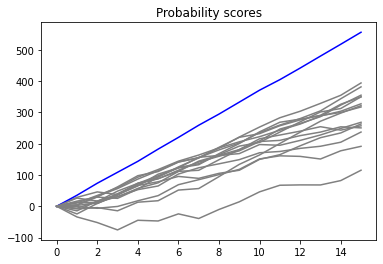

In [183]:
#probability scores when the target signal is v
prob_score_identity = prob_score(POIs_identity, 0, correct_key, 15,0)
#save to file
for k in range(16):
    filename = "Template_DPA/key" + str(k)
    savetofile(filename,prob_score_identity[k])

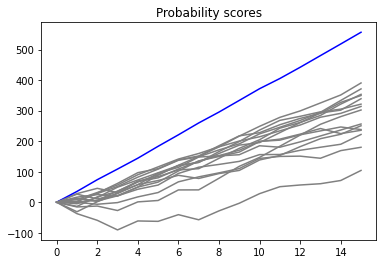

In [184]:
#probability scores when the target signal is v, assuming independence
prob_score(POIs_identity, 0, correct_key, 15,1);

In [25]:
#save data to file for tikz plot
def savetofile_single_POI(filename,array):
    f = open(filename+".txt", "w")
    f.write("x y\n")
    i = 0
    for i in range(1,len(array)):
        f.write(str(i)+" "+str(array[i][0])+"\n")
        i+=1
    f.close()

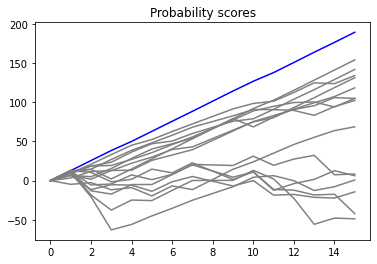

In [26]:
#probability scores when the target signal is v, just one POI
prob_score_identity_single_POI = prob_score([392], 0, correct_key, 15,0);
#save to file
for k in range(16):
    filename = "Template_DPA/single_POI_key" + str(k)
    savetofile_single_POI(filename,prob_score_identity_single_POI[k])

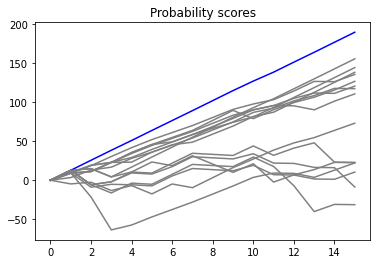

In [27]:
#probability scores when the target signal is Hamming weight of v, just one POI
prob_score_hw_single_POI = prob_score([392], 1, correct_key, 15,0);
#save to file
for k in range(16):
    filename = "Template_DPA/single_POI_key_hw" + str(k)
    savetofile_single_POI(filename,prob_score_hw_single_POI[k])

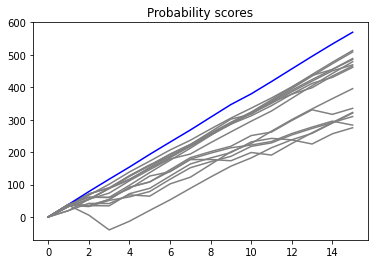

In [186]:
#probability scores when the target signal is hamming weight of v
prob_score_hw = prob_score(POIs_hw, 1, correct_key, 15, 0)
#save to file
for k in range(16):
    filename = "Template_DPA/hw_key" + str(k)
    savetofile(filename,prob_score_hw[k])

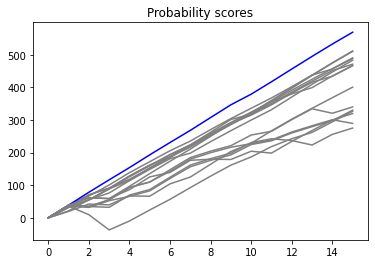

In [187]:
#probability scores when the target signal is hamming weight of v, assuming independence
prob_score(POIs_hw, 1, correct_key, 15, 1);

In [188]:
#Computing success rate and guessing entropy given the number of traces
def sr_ge_dpa(mean_vector, cov_matrix, no_of_traces, POIs, leakage_model, key_nibble, independence):
    ranks = []#store key rank in each simulated attack
    success_rate = 0
    
    for i in range(no_of_attack):#repeat no_of_attack attacks
        ind = indall[no_of_traces][i*no_of_traces:(i+1)*no_of_traces]
#         ind = random.sample(range(file_no),no_of_traces)
        traces = trace_array[ind]#leakges at POIs
        pts = plaintext_array[ind]#corresponding plaintext nibbles
        rk = compute_rank(template_prob_score(POIs, leakage_model, no_of_traces, pts, traces, mean_vector, cov_matrix, independence),key_nibble)
        ranks.append(rk)
        if(rk == 1):
            success_rate += 1
    success_rate = success_rate/no_of_attack
    return success_rate, statistics.mean(ranks)

In [189]:
#compute sucess rate and guessing entropy for different number of traces
def get_SR_GE(POI_no, total_traces,independence,key_nibble):
    SR_id = []
    GE_id = []
    SR_hw = []
    GE_hw = []
    if(POI_no == 3):
     #get templates
        mean_vector_id, cov_matrix_id = build_template(POIs_identity,0)
        mean_vector_hw, cov_matrix_hw = build_template(POIs_hw,1)
        for no_of_traces in range(2,total_traces):
          #signal = v
            sr_id,ge_id = sr_ge_dpa(mean_vector_id, cov_matrix_id, no_of_traces, POIs_identity, 0, key_nibble, independence)
            SR_id.append(sr_id)
            GE_id.append(ge_id)
           #signal = Hamming weight 
            sr_hw,ge_hw = sr_ge_dpa(mean_vector_hw, cov_matrix_hw, no_of_traces, POIs_hw, 1, key_nibble, independence)
            SR_hw.append(sr_hw)
            GE_hw.append(ge_hw)
    if(POI_no == 1):
        mean_vector_id, cov_matrix_id = build_template([392],0)
        mean_vector_hw, cov_matrix_hw = build_template([392],1)
        for no_of_traces in range(2,total_traces):
         #signal = v
            sr_id,ge_id = sr_ge_dpa(mean_vector_id, cov_matrix_id, no_of_traces, [392], 0, key_nibble, independence)
            SR_id.append(sr_id)
            GE_id.append(ge_id)
           #signal = Hamming weight 
            sr_hw,ge_hw = sr_ge_dpa(mean_vector_hw, cov_matrix_hw, no_of_traces, [392], 1, key_nibble, independence)
            SR_hw.append(sr_hw)
            GE_hw.append(ge_hw)
    
    # Placing the plots in the plane
    plot1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    plot2 = plt.subplot2grid((3, 3), (0, 2), rowspan=3, colspan=2)
    #plots
    plot1.plot(SR_id)
    plot1.plot(SR_hw)
    plot1.set_title('SR')
    plot2.plot(GE_id)
    plot2.plot(GE_hw)
    plot2.set_title('GE')

    # Packing all the plots and displaying them
    plt.tight_layout()
    plt.show()
    ##save to file
    savetofile("Template_DPA/SR" + str(POI_no) + "_independence_" + str(independence),SR_id)
    savetofile("Template_DPA/SR_hw" + str(POI_no)+ "_independence_" + str(independence),SR_hw)
    savetofile("Template_DPA/GE" + str(POI_no)+ "_independence_" + str(independence),GE_id)
    savetofile("Template_DPA/GE_hw" + str(POI_no)+ "_independence_" + str(independence),GE_hw)
    return

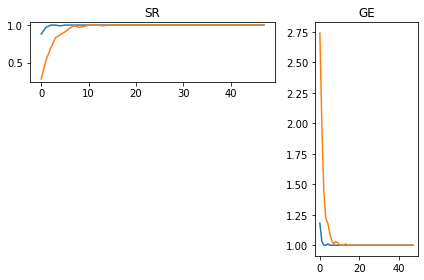

In [190]:
#3 POIs, maximum 50 traces, not independent
get_SR_GE(3, 50,0,correct_key)

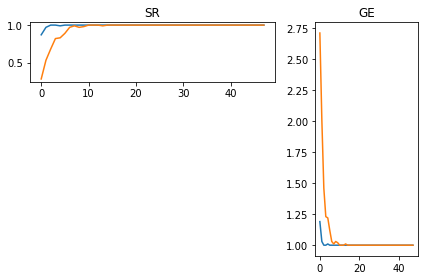

In [191]:
#3 POIs, maximum 50 traces, assuming independent
get_SR_GE(3, 50,1,correct_key)

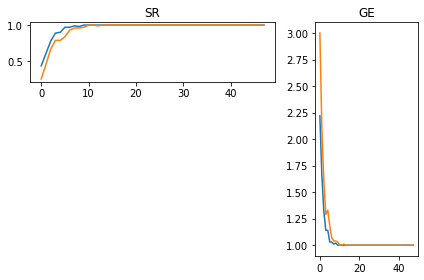

In [192]:
#1 POI, maximum 50 traces, not independent
get_SR_GE(1, 50,0,correct_key)